# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

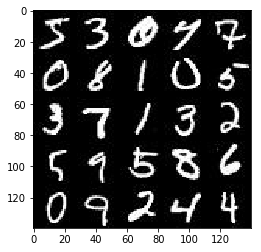

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

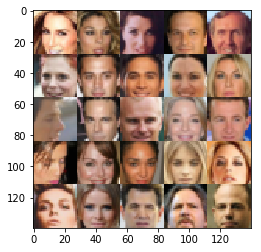

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/praveen.chaudhary/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,shape=(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return (input_real,input_z,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha=0.05
    
    with tf.variable_scope('discriminator',reuse=reuse):
        #Input Layer 28x28x3
        h1=tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        r1=tf.maximum(alpha*h1,h1)
        #16x16x32
        
        h2=tf.layers.conv2d(r1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2=tf.layers.batch_normalization(h2,training=True)
        r2=tf.maximum(alpha*bn2,bn2)
        #8x8x128
        
        h3=tf.layers.conv2d(r2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3=tf.layers.batch_normalization(h3,training=True)
        r3=tf.maximum(alpha*bn3,bn3)
        #4x4x256
        
        #Flattenning
        flat=tf.reshape(r3,(-1,4*4*256))
        logits=tf.layers.dense(flat,1)
        out=tf.sigmoid(logits)      
                
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.05
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        
        x2= tf.layers.conv2d_transpose(inputs=x1,filters=256,kernel_size=5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2,x2)
        
        x3= tf.layers.conv2d_transpose(inputs=x2,filters=128,kernel_size=5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3,x3)
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    
    input_real,input_z,lr= model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr=learning_rate
    
    d_loss, g_loss= model_loss(input_real, input_z, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples,losses=[],[]
    steps=0
    
    print_each=10
    show_each=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ =sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z})
                _=sess.run(g_opt,feed_dict={input_z:batch_z,input_real:batch_images})
              
                if steps % print_each == 0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))    
                    
                if steps % show_each == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)                  
                                                       
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                                                                                 
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 3.6005
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 0.3725... Generator Loss: 5.5692
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 2.8478
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 2.4564
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.6520
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 1.1025
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.9249


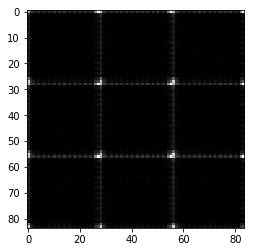

Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 1.0121
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 1.2320


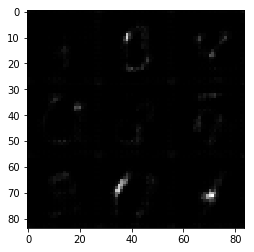

Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.5434
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 1.2173
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 1.4246
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.1182... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.9629


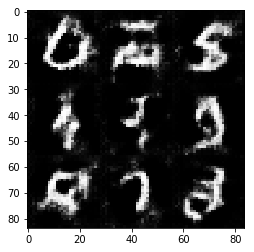

Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.2410
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.8635
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.9144
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 1.0819
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.9524


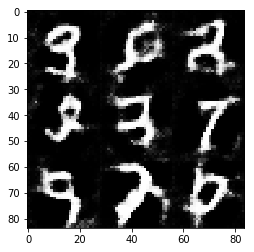

Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.2091
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 1.1642
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.2632
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.0227
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 1.0849... Generator Loss: 0.9262


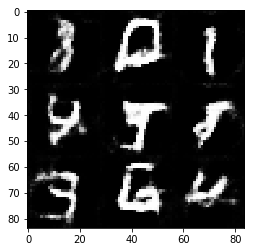

Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 1.1158
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 1.9769
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 1.6526... Generator Loss: 0.3748
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.0273... Generator Loss: 0.9851


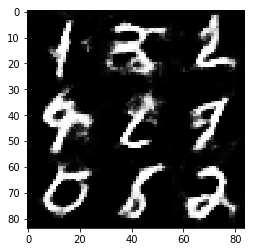

Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 1.4294
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.8972


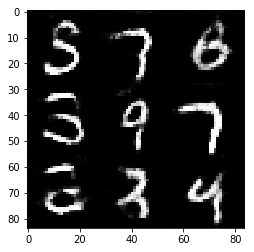

Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.4457
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 0.9774... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 1.3256
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 1.0705
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.8356


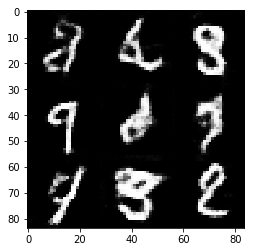

Epoch 1/2... Discriminator Loss: 0.9498... Generator Loss: 1.1350
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 1.3686
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 1.9558
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.6570
Epoch 1/2... Discriminator Loss: 1.9448... Generator Loss: 0.3580
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 1.2564
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.9264


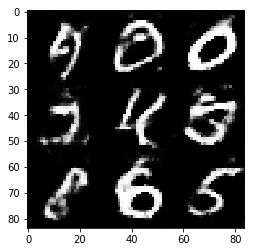

Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.1588
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.1800
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 1.5488


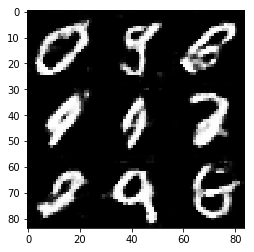

Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 1.1095
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 2.0638
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 1.1369
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 0.9953


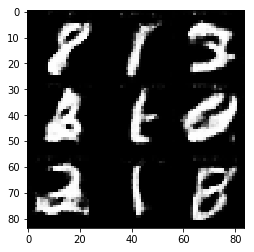

Epoch 2/2... Discriminator Loss: 1.6539... Generator Loss: 2.5517
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 1.0666
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.8098... Generator Loss: 0.3346
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.9753


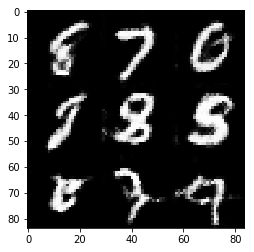

Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.2356
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 1.0377
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 1.4963... Generator Loss: 0.4381
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.6389
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 2.6679


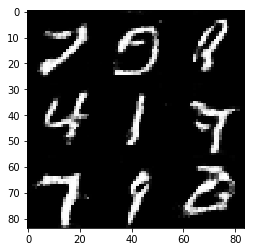

Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 1.1310
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 1.2932
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 2.3282
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.2988
Epoch 2/2... Discriminator Loss: 1.3202... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.0208... Generator Loss: 1.8934
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 1.7501


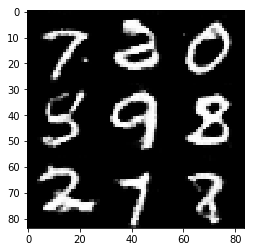

Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 1.1804
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.4975
Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 1.5498
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 1.6311
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.0109
Epoch 2/2... Discriminator Loss: 0.8326... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.6936


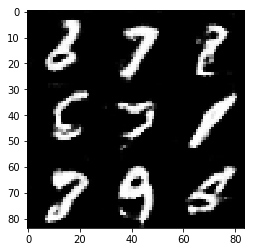

Epoch 2/2... Discriminator Loss: 1.2397... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.7761
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.5549
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.0704
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 1.6867
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 0.9725
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.2598


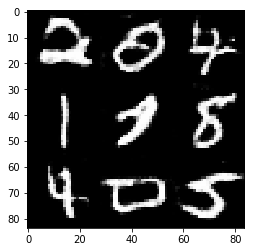

Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.0901
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.1130
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 1.8860
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.6854


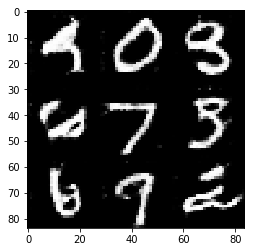

Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.2185
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.5780
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.3248
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.3418
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.6282
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 1.4432
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.3735
Epoch 2/2... Discriminator Loss: 0.9361... Generator Loss: 1.0347


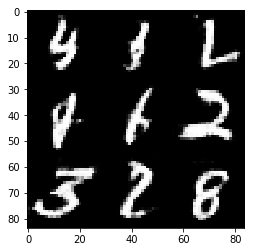

Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.0531
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.5457
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.9932
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.5065


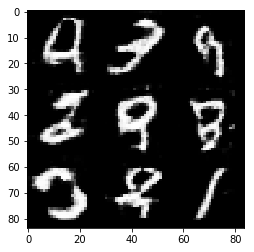

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.4147
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.8859
Epoch 1/1... Discriminator Loss: 2.0354... Generator Loss: 0.3224
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.5719
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.3561
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.9398
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 2.8546


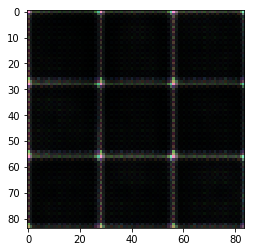

Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.3273
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.3361
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 2.3662
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 5.3040
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.5887


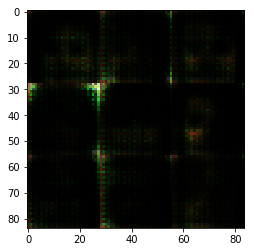

Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 2.7476
Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 2.0609
Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 1.9523
Epoch 1/1... Discriminator Loss: 2.0250... Generator Loss: 0.2853
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 4.7618
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.5633
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 4.0104
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.8248


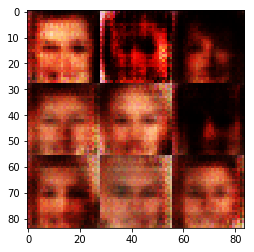

Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.4810
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 4.5553
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 3.4105
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 4.4407
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 2.0207
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 4.1625
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 3.0178
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.5836


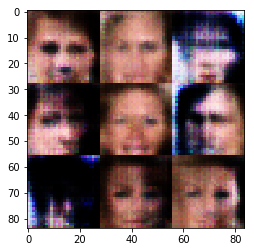

Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 2.9068
Epoch 1/1... Discriminator Loss: 1.7650... Generator Loss: 4.3642
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.0856
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 2.1369
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 2.4814
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.5808


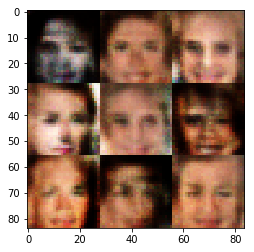

Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 2.1128
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 2.7271
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 2.6225
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 3.0624


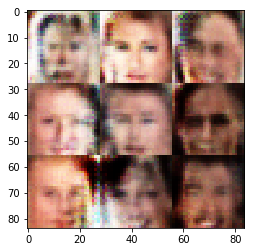

Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.6396
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 3.0922
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 2.0082... Generator Loss: 4.3767
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 1.9380... Generator Loss: 0.2742
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.7103


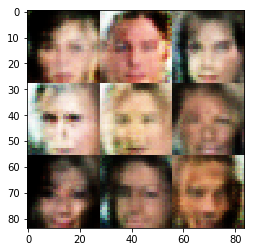

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 1.8482... Generator Loss: 0.3383
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.2105


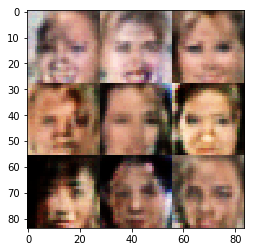

Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.4822
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.8410
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.9163
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 3.3665
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.0754


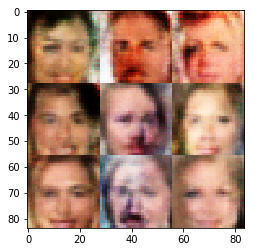

Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.3526
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.4807
Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 2.3826
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 3.5117
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.9472


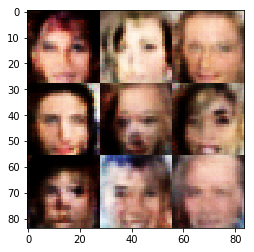

Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.0908
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.8329
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7759


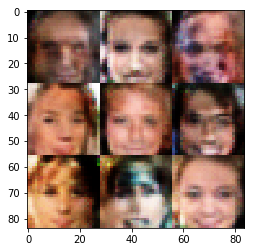

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 1.7753... Generator Loss: 1.8888
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.4563
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 2.3844
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.8525
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.9268


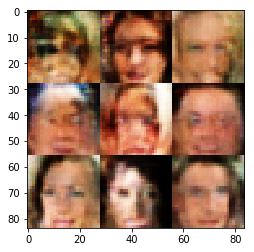

Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.8663
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 0.9195


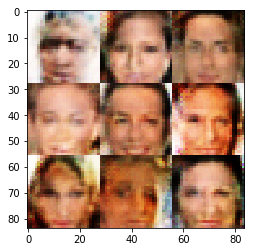

Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 2.2976
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 2.1190
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 2.9727


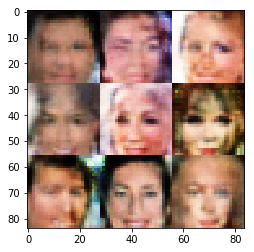

Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 3.8916
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 3.4321
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.9347
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.4351


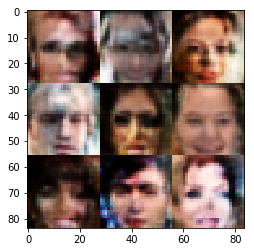

Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.5331
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 2.4982
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 2.7313
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.6370


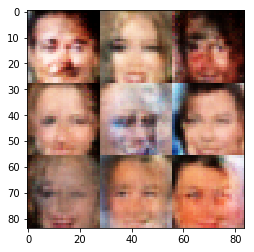

Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 3.1018
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.7379
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.5551
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 2.0851
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.9487... Generator Loss: 0.2657
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.0168


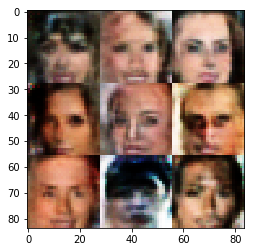

Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 2.2856
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 1.7868
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 2.6290
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 3.0513
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 3.2187
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.8229


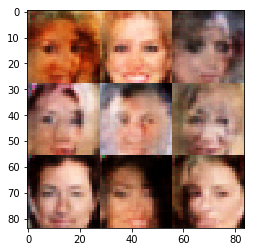

Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.6455
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.7524
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 2.0314... Generator Loss: 2.5387
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 3.0810
Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.4650


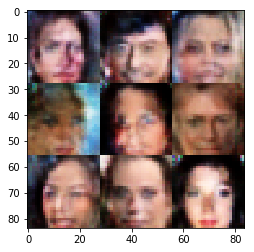

Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.7218... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.7475
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.4295
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.7067
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 3.3157


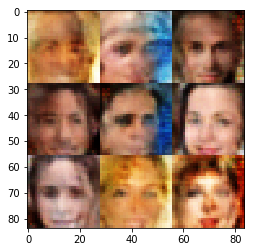

Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.3986
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.5503
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 2.0701
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.9761


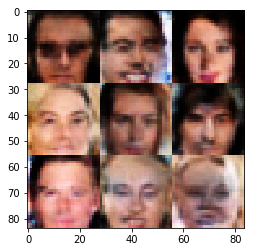

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 2.4212
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.7136... Generator Loss: 2.5319
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 3.0528
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.3726
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.9104
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.3536
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.7808


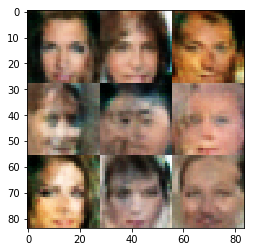

Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 2.0233
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.8775
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 2.3086
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 3.6333
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 3.1073


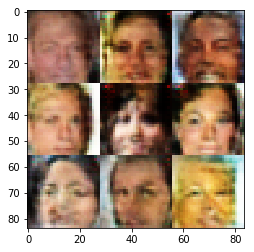

Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.4987
Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 1.4189
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.9309
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.1119
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.6807


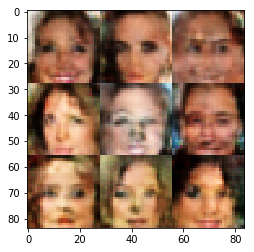

Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.5467
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 2.2922
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.9452


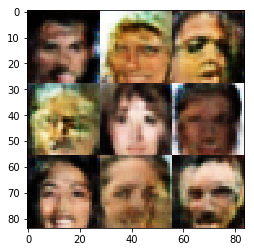

Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.5511


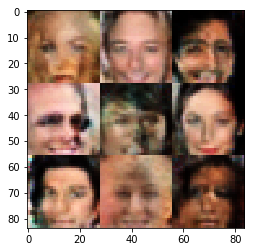

Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.3396
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 2.0336
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 3.0270
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 4.4241
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9985


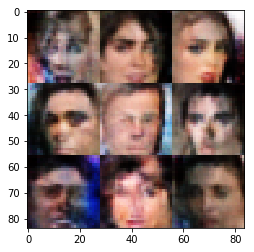

Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 1.8220
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.3838
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 4.5056
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.7713


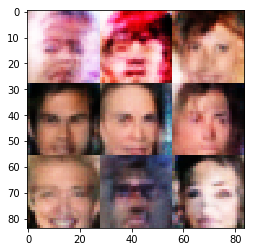

Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 2.2724
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 2.1121
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 1.5693


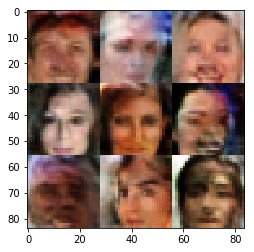

Epoch 1/1... Discriminator Loss: 2.6422... Generator Loss: 0.1230
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 1.3316


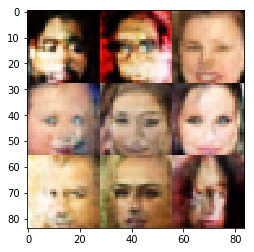

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 3.5416
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0535


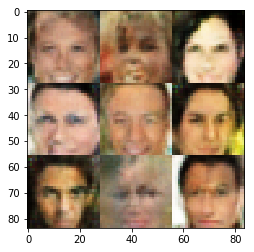

Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4869


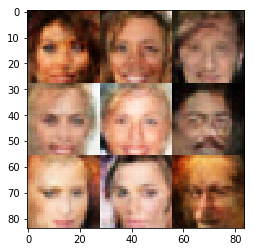

In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.